<a href="https://colab.research.google.com/github/ValerieLangat/DS-Unit-2-Classification-2/blob/master/making%20%26%20explaining%20decisions(replicating%20lecture%20and%20fixed%20my%20errors).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install category_encoders shap

In [0]:
import pandas as pd
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

In [0]:
history_location = '../data/lending-club-subset.csv'
current_location = '../data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

history_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/lending-club-subset.csv'
current_location = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Classification-2/master/data/primaryMarketNotes_browseNotes_1-RETAIL.csv'

history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)
current = pd.read_csv(current_location)

In [0]:
history['earliest_cr_line'] = pd.to_datetime(history['earliest_cr_line'], infer_datetime_format=True)
history['earliest_cr_line'] = history['issue_d'] - history['earliest_cr_line']
history['earliest_cr_line'] = history['earliest_cr_line'].dt.days

current['earliest_cr_line'] = pd.to_datetime(current['earliest_cr_line'], infer_datetime_format=True)
current['earliest_cr_line'] = pd.Timestamp.today() - current['earliest_cr_line']
current['earliest_cr_line'] = current['earliest_cr_line'].dt.days

history['sec_app_earliest_cr_line'] = pd.to_datetime(history['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
history['sec_app_earliest_cr_line'] = history['issue_d'] - history['sec_app_earliest_cr_line']
history['sec_app_earliest_cr_line'] = history['sec_app_earliest_cr_line'].dt.days

current['sec_app_earliest_cr_line'] = pd.to_datetime(current['sec_app_earliest_cr_line'], infer_datetime_format=True, errors='coerce')
current['sec_app_earliest_cr_line'] = pd.Timestamp.today() - current['sec_app_earliest_cr_line']
current['sec_app_earliest_cr_line'] = current['sec_app_earliest_cr_line'].dt.days

history['issue_d_year'] = history['issue_d'].dt.year
history['issue_d_month'] = history['issue_d'].dt.month

current['issue_d_year'] = pd.Timestamp.today().year
current['issue_d_month'] = pd.Timestamp.today().month


In [0]:
history['percent_paid'] = history['total_pymnt'] / history['funded_amnt']

In [6]:
target = 'loan_status'
X = history.drop(columns=target)
y = history[target]

from sklearn.model_selection import train_test_split

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=20000, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=20000, 
    stratify=y_trainval, random_state=42)

print('X_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('X_val shape', X_val.shape)
print('y_val shape', y_val.shape)
print('X_test shape', X_test.shape)
print('y_test shape', y_test.shape)

X_train shape (88334, 152)
y_train shape (88334,)
X_val shape (20000, 152)
y_val shape (20000,)
X_test shape (20000, 152)
y_test shape (20000,)


In [7]:
cols = ['id', 'issue_d', 'grade', 'percent_paid', 'term', 'int_rate']
result_train = X_train[cols].copy()
result_val = X_val[cols].copy()
result_test = X_test[cols].copy()

result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [0]:
common_columns = set(history.columns) & set(current.columns)
just_history = set(history.columns) - set(current.columns)
just_current = set(current.columns) - set(history.columns)

features = list(common_columns)
X_train = X_train[features]
X_val = X_val[features]
X_test = X_test[features]

In [9]:
def wrangle(X):
    X = X.copy()

    for col in X:
        X[col+'_NULL'] = X[col].isnull()
    
    X['int_rate'] = X['int_rate'].str.strip('%').astype(float)
    X['revol_util'] = X['revol_util'].str.strip('%').astype(float)
    
    X['emp_length'] = X['emp_length'].str.replace(r'\D','').astype(float)
        
    X['emp_title'] = X['emp_title'].str.lower()
    X['emp_title_teacher'] = X['emp_title'].str.contains('teacher', na=False)
    X['emp_title_manager'] = X['emp_title'].str.contains('manager', na=False)
    X['emp_title_owner']   = X['emp_title'].str.contains('owner', na=False)

    X['title'] = X['title'].str.len()
    X['desc'] = X['desc'].str.len()
    X['emp_title'] = X['emp_title'].str.len()
    
    sub_grade_ranks = {'A1': 1, 'A2': 2, 'A3': 3, 'A4': 4, 'A5': 5, 'B1': 6, 'B2': 7, 
                       'B3': 8, 'B4': 9, 'B5': 10, 'C1': 11, 'C2': 12, 'C3': 13, 'C4': 14, 
                       'C5': 15, 'D1': 16, 'D2': 17, 'D3': 18, 'D4': 19, 'D5': 20}
    X['sub_grade'] = X['sub_grade'].map(sub_grade_ranks)
    
    X = X.drop(columns='id')        
    X = X.drop(columns='url')       
    X = X.drop(columns='member_id') 
    X = X.drop(columns='grade')     
    X = X.drop(columns='zip_code')  
        
    features = ['acc_open_past_24mths', 'addr_state', 'all_util', 'annual_inc', 
                'annual_inc_joint', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 
                'collections_12_mths_ex_med', 'delinq_amnt', 'desc_NULL', 'dti', 
                'dti_joint', 'earliest_cr_line', 'emp_length', 'emp_length_NULL', 
                'emp_title', 'emp_title_NULL', 'emp_title_owner', 'fico_range_high', 
                'funded_amnt', 'home_ownership', 'inq_last_12m', 'inq_last_6mths', 
                'installment', 'int_rate', 'issue_d_month', 'issue_d_year', 'loan_amnt', 
                'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
                'mo_sin_rcnt_rev_tl_op', 'mort_acc', 'mths_since_last_major_derog_NULL', 
                'mths_since_last_record', 'mths_since_recent_bc', 'mths_since_recent_inq', 
                'num_actv_bc_tl', 'num_actv_rev_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 
                'num_tl_120dpd_2m_NULL', 'open_rv_12m_NULL', 'open_rv_24m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'purpose', 
                'revol_bal', 'revol_bal_joint', 'sec_app_earliest_cr_line', 
                'sec_app_fico_range_high', 'sec_app_open_acc', 'sec_app_open_act_il', 
                'sub_grade', 'term', 'title', 'title_NULL', 'tot_coll_amt', 
                'tot_hi_cred_lim', 'total_acc', 'total_bal_il', 'total_bc_limit', 
                'total_cu_tl', 'total_rev_hi_lim']    
    X = X[features]
    
    return X


X_train = wrangle(X_train)
X_val   = wrangle(X_val)
X_test  = wrangle(X_test)

print('X_train shape', X_train.shape)
print('X_val shape', X_val.shape)
print('X_test shape', X_test.shape)

X_train shape (88334, 66)
X_val shape (20000, 66)
X_test shape (20000, 66)


In [10]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.669638	validation_1-auc:0.672822
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.670802	validation_1-auc:0.674118
[2]	validation_0-auc:0.676142	validation_1-auc:0.680087
[3]	validation_0-auc:0.679771	validation_1-auc:0.683186
[4]	validation_0-auc:0.682482	validation_1-auc:0.684256
[5]	validation_0-auc:0.683905	validation_1-auc:0.685868
[6]	validation_0-auc:0.685104	validation_1-auc:0.687372
[7]	validation_0-auc:0.685857	validation_1-auc:0.687737
[8]	validation_0-auc:0.685805	validation_1-auc:0.687888
[9]	validation_0-auc:0.686504	validation_1-auc:0.689168
[10]	validation_0-auc:0.686866	validation_1-auc:0.689461
[11]	validation_0-auc:0.686938	validation_1-auc:0.689288
[12]	validation_0-auc:0.687537	validation_1-auc:0.69022
[13]	validation_0-auc:0.688371	validation_1-auc:0.690954
[14]	validation_0-auc:0.688811	validation_1-auc:0.691599

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

.

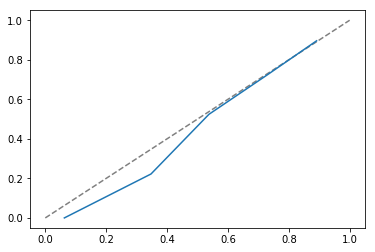

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
y_pred_proba = model.predict_proba(X_val_processed)[:, 1]
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=5)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

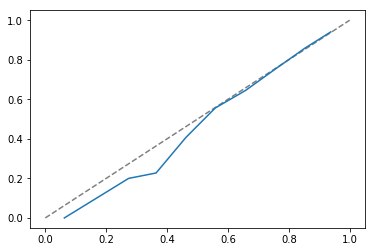

In [12]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=10)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

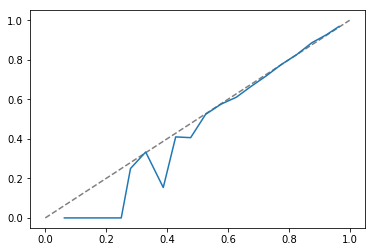

In [13]:
prob_true, prob_pred = calibration_curve(y_val, y_pred_proba, n_bins=20)
plt.plot((0,1), (0,1), linestyle='--', color='grey')
plt.plot(prob_pred, prob_true);

In [0]:
def get_results(result_df, y_true, y_pred_proba):
    result_df = result_df.copy()
    result_df['loan_status'] = y_true
    result_df['pred_proba'] = y_pred_proba
    result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
    result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
    result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
    result_df['best_case'] = 25 + result_df['max_interest']/100 * 25
    result_df['worst_case'] = -25
    result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case'] 
                                   + (1-result_df['pred_proba']) * result_df['worst_case'])
    return result_df

result_val2 = get_results(result_val, y_val, y_pred_proba)

In [15]:
result_val.head()

,id,issue_d,grade,percent_paid,term,int_rate
47563,11336218.0,2014-01-01,D,1.439103,60 months,16.99%
83314,127629418.0,2018-01-01,D,1.172302,36 months,20.00%
740,555478.0,2010-08-01,D,1.217144,36 months,15.95%
60350,106493943.0,2017-04-01,C,1.158069,60 months,12.74%
121119,68368766.0,2016-01-01,A,1.048598,36 months,5.32%


In [16]:
result_val.describe()

,id,percent_paid
count,2.000000e+04,20000.000000
mean,5.959835e+07,1.041970
std,3.961624e+07,0.267876
min,1.336850e+05,0.000000
25%,2.274274e+07,1.044298
50%,6.136165e+07,1.113421
75%,8.869767e+07,1.182077
max,1.493697e+08,1.599994


In [0]:
%matplotlib inline
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from scipy.stats import percentileofscore
import seaborn as sns
from tqdm import tnrange

def simulate(df, n_picks=40, n_sims=10000, 
             grades=['A','B','C'], 
             start_date='2007-07-01', 
             end_date='2019-03-01', 
             min_expected_value=-25):
    
    condition = ((df['grade'].isin(grades)) & 
                 (df['issue_d'] >= start_date) &
                 (df['issue_d'] <= end_date) & 
                 (df['expected_value'] >= min_expected_value))
    possible = df[condition]
    
    simulations = []
    for _ in tnrange(n_sims):
        picks = possible.sample(n_picks).copy()
        picks['paid'] = 25 * picks['percent_paid']
        paid = picks['paid'].sum()
        simulations.append(paid)
        
    simulations = pd.Series(simulations)
    sns.distplot(simulations)
    plt.axvline(x=1000)
    percent = percentileofscore(simulations, 1000)
    print(f'#### {n_picks} loans picked from {len(possible)} possible loans')
    print(f'- Dates: {start_date}-{end_date}\n' + 
                     f'- Grades: {grades}\n' +
                     f'- Expected Value >= {min_expected_value}')
    print(f'#### Range of results from {n_sims} simulations')
    print(simulations.describe().to_string())
    plt.title(f'{percent}% of simulations did not profit.')

In [0]:
def get_results(result_df, y_true, y_pred_proba):
  result_df = result_df.copy()
  result_df['loan_status'] = y_true
  result_df['pred_proba'] = y_pred_proba
  result_df['int_rate'] = result_df['int_rate'].str.strip('%').astype(float)
  result_df['term'] = result_df['term'].str.replace(r'\D','').astype(int)
  result_df['max_interest'] = result_df['int_rate'] * result_df['term'] / 12
  result_df['best_case'] = 25 + result_df['max_interest']/100 * 12
  result_df['worst_case'] = -25
  result_df['expected_value'] = (result_df['pred_proba'] * result_df['best_case']
                                + (1-result_df['pred_proba']) * result_df['worst_case'])
  return result_df

result_val = get_results(result_val, y_val, y_pred_proba)


#### 40 loans picked from 3986 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A']
- Expected Value >= -25
#### Range of results from 10000 simulations
count    10000.000000
mean      1051.670950
std         23.275110
min        931.274787
25%       1037.427734
50%       1054.438377
75%       1068.743208
max       1100.658355


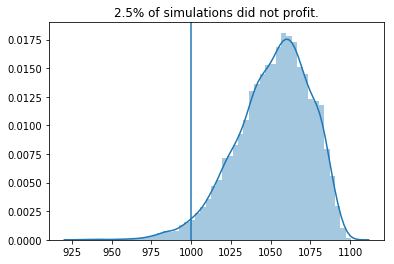

In [19]:
simulate(result_val, grades=['A'])


#### 40 loans picked from 3879 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C']
- Expected Value >= 24.462529283437725
#### Range of results from 10000 simulations
count    10000.000000
mean      1078.573395
std         23.298187
min        951.598878
25%       1064.396342
50%       1080.928941
75%       1095.302119
max       1146.759307


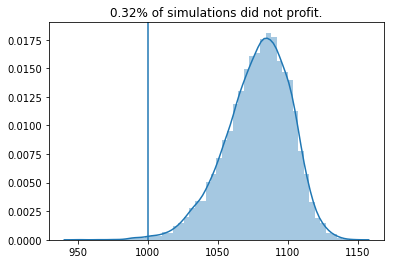

In [20]:
import numpy as np
min_expected_value = np.percentile(result_val['expected_value'], 80)
simulate(result_val, min_expected_value=min_expected_value)

In [21]:
from sklearn.metrics import roc_auc_score
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.709825059932263



#### 40 loans picked from 3889 possible loans
- Dates: 2007-07-01-2019-03-01
- Grades: ['A', 'B', 'C']
- Expected Value >= 24.429211863713263
#### Range of results from 10000 simulations
count    10000.000000
mean      1077.180461
std         23.769387
min        975.847607
25%       1062.194231
50%       1079.931455
75%       1094.688116
max       1140.069096


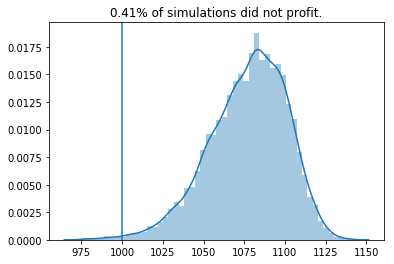

In [22]:
result_test = get_results(result_test, y_test, y_pred_proba)
min_expected_value = np.percentile(result_test['expected_value'], 80)
simulate(result_test, min_expected_value=min_expected_value)

In [23]:
df = result_test.copy()
condition = (df['expected_value'] >= min_expected_value)
possible = df[condition]
picks = possible.sample(40, random_state=42).copy()
picks

,id,issue_d,grade,percent_paid,term,int_rate,loan_status,pred_proba,max_interest,best_case,worst_case,expected_value
6576,74571347.0,2016-03-01,A,1.083517,36,6.49,Fully Paid,0.949349,19.47,27.3364,-25,24.685530
14749,1561334.0,2012-10-01,D,1.176960,36,17.77,Fully Paid,0.877223,53.31,31.3972,-25,24.472905
95610,38584793.0,2015-01-01,A,1.101658,36,6.49,Fully Paid,0.951675,19.47,27.3364,-25,24.807234
110065,57194344.0,2015-07-01,A,1.086510,36,6.24,Fully Paid,0.958250,18.72,27.2464,-25,25.065115
74620,1854825.0,2013-03-01,A,1.092510,36,6.03,Fully Paid,0.984962,18.09,27.1708,-25,26.386242
57282,25767089.0,2014-09-01,A,1.095679,36,6.03,Fully Paid,0.980445,18.09,27.1708,-25,26.150617
7873,3544820.0,2013-03-01,C,1.253423,36,15.31,Fully Paid,0.911255,45.93,30.5116,-25,25.585230
84330,58270569.0,2015-08-01,A,1.082530,36,5.32,Fully Paid,0.981886,15.96,26.9152,-25,25.974803
16513,6805778.0,2013-09-01,B,1.196140,36,13.05,Fully Paid,0.927338,39.15,29.6980,-25,25.723541
60421,102466690.0,2017-03-01,A,1.029605,36,7.49,Fully Paid,0.965978,22.47,27.6964,-25,25.903546


In [24]:
data_for_prediction = X_test[X_test.index==106384]
data_for_prediction

,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,avg_cur_bal,bc_open_to_buy,bc_util,collections_12_mths_ex_med,delinq_amnt,desc_NULL,dti,dti_joint,earliest_cr_line,emp_length,emp_length_NULL,emp_title,emp_title_NULL,emp_title_owner,fico_range_high,funded_amnt,home_ownership,inq_last_12m,inq_last_6mths,installment,int_rate,issue_d_month,issue_d_year,loan_amnt,max_bal_bc,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_last_major_derog_NULL,mths_since_last_record,mths_since_recent_bc,mths_since_recent_inq,num_actv_bc_tl,num_actv_rev_tl,num_op_rev_tl,num_rev_tl_bal_gt_0,num_tl_120dpd_2m_NULL,open_rv_12m_NULL,open_rv_24m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,purpose,revol_bal,revol_bal_joint,sec_app_earliest_cr_line,sec_app_fico_range_high,sec_app_open_acc,sec_app_open_act_il,sub_grade,term,title,title_NULL,tot_coll_amt,tot_hi_cred_lim,total_acc,total_bal_il,total_bc_limit,total_cu_tl,total_rev_hi_lim
106384,0.0,FL,NaN,140000.0,NaN,30333.0,26371.0,43.9,0.0,0.0,True,15.22,NaN,7548,10.0,False,16.0,False,False,724.0,33000.0,MORTGAGE,NaN,1.0,1090.88,11.67,6,2014,33000.0,NaN,205.0,247.0,28.0,3.0,True,NaN,30.0,1.0,5.0,9.0,11.0,9.0,False,True,NaN,100.0,33.3,0.0,credit_card,31786.0,NaN,NaN,NaN,NaN,NaN,9,36 months,23.0,False,0.0,615094.0,34.0,NaN,47000.0,NaN,60600.0


In [0]:
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns

In [26]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

/usr/local/lib/python3.6/dist-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [27]:
shap.initjs()
data_for_prediction = X_test[X_test.index==120043]
data_for_prediction
data_for_prediction_processed = processor.transform(data_for_prediction)
data_for_prediction_processed = pd.DataFrame(data_for_prediction_processed)
data_for_prediction_processed.columns = data_for_prediction.columns
shap_values = explainer.shap_values(data_for_prediction_processed)
shap.force_plot(explainer.expected_value, shap_values, data_for_prediction_processed)

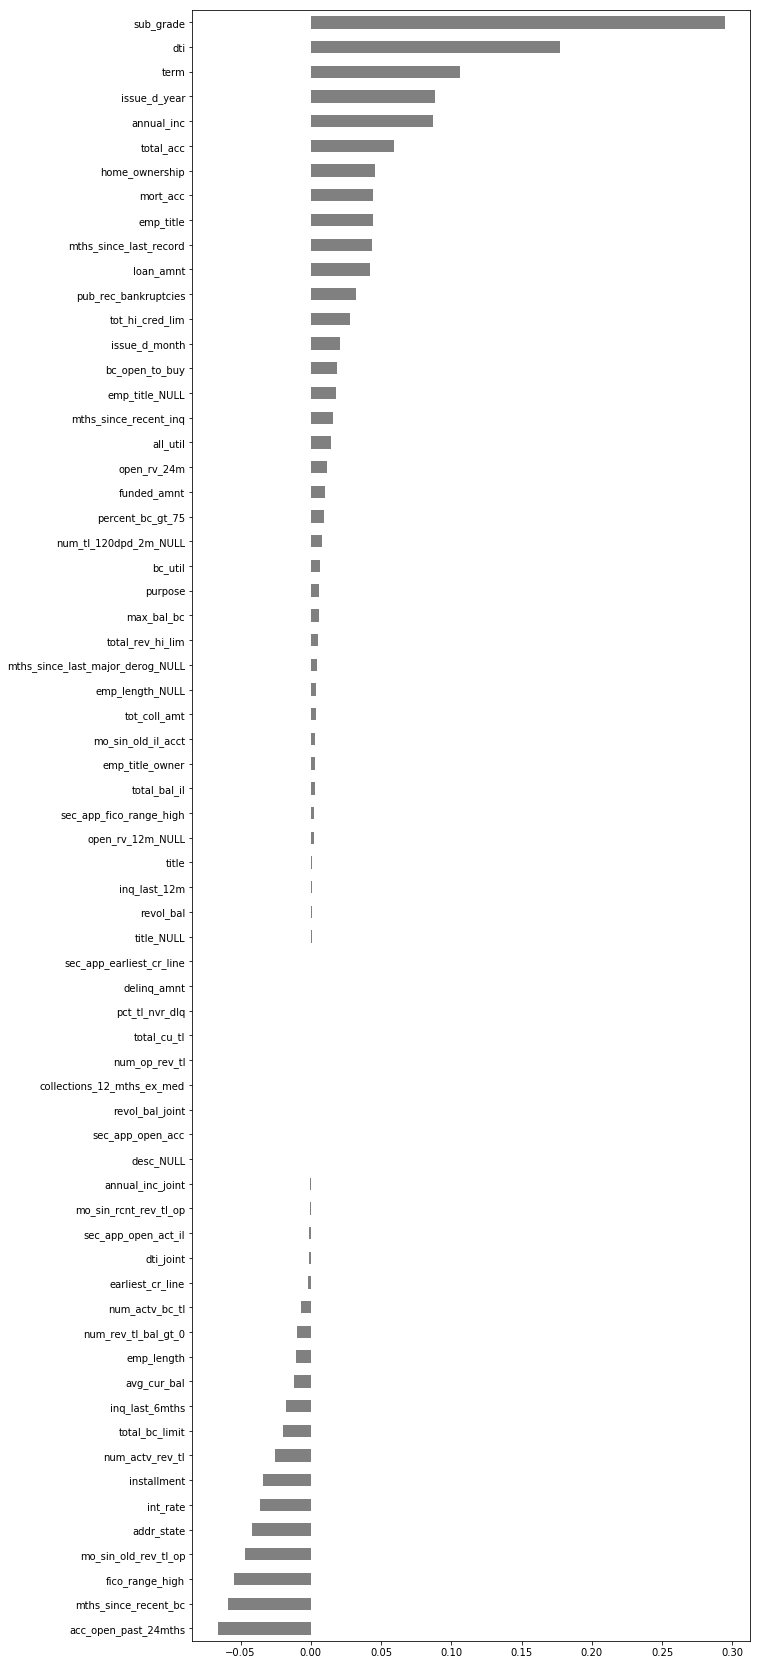

In [28]:
plt.figure(figsize=(10,30))
pd.Series(shap_values[0], X_test.columns).sort_values().plot.barh(color='grey');

In [29]:
pd.Series(shap_values[0], X_test.columns)

acc_open_past_24mths               -0.066378
addr_state                         -0.041963
all_util                            0.014394
annual_inc                          0.087251
annual_inc_joint                   -0.000398
avg_cur_bal                        -0.012074
bc_open_to_buy                      0.018365
bc_util                             0.006860
collections_12_mths_ex_med          0.000144
delinq_amnt                         0.000296
desc_NULL                           0.000000
dti                                 0.177436
dti_joint                          -0.001312
earliest_cr_line                   -0.002038
emp_length                         -0.010642
emp_length_NULL                     0.003927
emp_title                           0.043965
emp_title_NULL                      0.017792
emp_title_owner                     0.003039
fico_range_high                    -0.054699
funded_amnt                         0.010129
home_ownership                      0.045396
inq_last_1